# **Debt Intolerance Threshold Simulation-Japan**

Based on Reinhart C., Rogoff K. & Savastano M., 2003, *Debt Intolerance*, National Bureau of Economic Research, Working Paper Series, August 2003, USA

### **Introduction**

The following simulation aims to assess whether and under which intensity history matters in forecasting Japan's ability to sustain, from moderate to high, levels of external indebtedness. When we refer to history, we mean a country's records at meeting its debt obligations and managing its macroeconomy, which result to be highly dependent from consolidated fiscal structures and financial systems seldom varying across years. We also define a "safe" debt threshold as the marginal forecasted value of S&P credit ranking under which the tested country is downgraded to a lower cluster within its macrogroup (Club A, Club B & Club C, according to Reinhart, 2003). From these assumptions, we develop an empirical model that includes a very few number of variables attempting to represent in the best way the impact of the three major forces shaping debt sustainability dynamics: repayment history, indebtness level and history of macroeconomic stability. It is worth to mention that the presented empirical approach includes also a new proxy capturing the effect of political stability and, hence, an assumed higher farshightedness in macroeconomic and budgetting policy planning in the Japanese political framework. More room within the model is also dedicated to the impact of inflation dydanimcs from a comparative prespective, with respect to the existing literature.

### **Preliminary steps**

In [1]:
!pip install pandas
!pip install matplotlib
!pip install requests-html
!pip install numpy
!pip install statsmodels
!pip install scipy
!pip install linearmodels
!pip install jpstat
!pip install wbgapi
!pip install fredapi

In [2]:
import os
import pandas as pd
from requests_html import HTMLSession
import jpstat
import json
import sys
from fredapi import Fred

In [3]:
# freadpi setting
fred = Fred(api_key="a8f0cdf1d0b64d1188b9c64ed64c77b6")

### **Data Import**

##### 0) Y = Japan's S&P credit rating 

In [4]:
import pandas as pd
from pandas import DataFrame 

In [5]:
# Retrieving data for Japan's S&P credit rating over time
# given data sources' scarsity in API or csv format, we must retrieve and import data manually
# sources: - S&P: https://secure.signin.spglobal.com/oauth2/spglobal/v1/authorize?client_id=RTG_SPCOM_OIDC_SPA&code_challenge=8q3pk87d9OsXsPcSEsEqDU73ebAgrrgGisBktknk-Mo&code_challenge_method=S256&display=en&nonce=eUZBTBrwiWo8teViVnCDX5nPjuGGPAksQ0iJGCn8Dt2dulpGVOFyHcQBM9hL4MFp&redirect_uri=https%3A%2F%2Fdisclosure.spglobal.com%2Fcallback&response_type=code&state=ANPnbEi0sjdBw4IIkJfXAM92WE70SrJetdBMt9HrQ2p5uyyVtbtIUpUqzSSekCZv&scope=openid%20email%20profile%20offline_access%20rtg_spcom%20ratings  
#          - World Government Bonds: https://www.worldgovernmentbonds.com/credit-rating/japan/?utm_content=cmp-true 

# since the S&P credit rating is a measuring scale of a country's crediworthiness alpahabetically expessed as a string, we want to convert it into a numerical scale to better fit our regressive model
SP_ratings = ["BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "BBB", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AAA", "AA+", "AA-", "AA-", "AA-", "AA-", "AA-", "AA", "AA", "AA", "AA", "AA-", "AA-", "AA-", "AA-", "A+", "A+", "A+", "A+", "A+", "A+", "A+", "A+"]

def numerical(ratings):
    
    numerical_values=[]

    for rating in ratings:
        if rating=="AAA":
            num=100
        elif rating=="AA+":
            num=96
        elif rating=="AA":
            num=92
        elif rating=="AA-":
            num=88
        elif rating=="A+":
            num=84
        elif rating=="A":
            num=80
        elif rating=="A-":
            num=76
        elif rating=="BBB+":
            num=72
        elif rating=="BBB":
            num=68
        elif rating=="BBB-":
            num=64
        elif rating=="BB+":
            num=60
        elif rating=="BB":
            num=56
        elif rating=="BB-":
            num=52
        elif rating=="B+":
            num=48
        elif rating=="B":
            num=44
        elif rating=="B-":
            num=40
        elif rating=="CCC+":
            num=36
        elif rating=="CCC":
            num=32
        elif rating=="CCC-":
            num=28
        elif rating=="CC":
            num=24
        elif rating=="C":
            num=20
        elif rating=="RD":
            num=16
        elif rating=="SD":
            num=12
        elif rating=="D_NR":
            num=0
        else:
            num=None
        
        numerical_values.append(num)

    # the return function must go outside the loop to ensure that the loop won't stop at the very first observation 
    return numerical_values        

In [6]:
# set the dictionary
SP_data = {"Year":list(range(1959, 2023)),
         "S&P credit rating": SP_ratings,
         "Numerical Index": numerical(SP_ratings) 
         }

# convert the dictionary to pandas dataframe
SPdf = pd.DataFrame(SP_data)

# dataframe manipulation
SPdf = SPdf.drop(0)
SPdf = SPdf.reset_index(inplace=False)
SPdf = SPdf.drop("index", axis=1)
SPdf["Year"] = pd.to_datetime(SPdf["Year"], format="%Y", errors="coerce")
SPdf["Year"] = SPdf["Year"].dt.strftime("%Y") 

print(DataFrame(SPdf))

    Year S&P credit rating  Numerical Index
0   1960               BBB               68
1   1961               BBB               68
2   1962               BBB               68
3   1963               BBB               68
4   1964               BBB               68
..   ...               ...              ...
58  2018                A+               84
59  2019                A+               84
60  2020                A+               84
61  2021                A+               84
62  2022                A+               84

[63 rows x 3 columns]


##### 1) X1 = Japan's Inflation rate trends 

In [7]:
import os
import fredapi as fa
import pandas as pd
from fredapi import Fred

In [8]:
# Retrieving data for Japan's Inflation rate over time 
# sources: - FRED: https://fred.stlouisfed.org/series/FPCPITOTLZGJPN 
# frequency: annual
# time span (year): 1960-2022
# dataframe tag: percentage growth in CPI

CPI_data = fred.get_series("FPCPITOTLZGJPN")
CPI_data = CPI_data.to_frame()
print(CPI_data)

                   0
1960-01-01  3.574512
1961-01-01  5.368462
1962-01-01  6.835440
1963-01-01  6.706906
1964-01-01  3.800389
...              ...
2018-01-01  0.989095
2019-01-01  0.468776
2020-01-01 -0.024996
2021-01-01 -0.233353
2022-01-01  2.497703

[63 rows x 1 columns]


In [9]:
# convert the dataframe to pandas dataframe
CPIdf = pd.DataFrame(CPI_data)

# dataframe manipulation
CPIdf = CPIdf.reset_index(inplace=False)
CPIdf = CPIdf.rename(columns={"index":"Year", 0:"Inflation Rate"})
CPIdf["Year"] = pd.to_datetime(CPIdf["Year"], format="%Y-%m-%d", errors="coerce") 
CPIdf["Year"] = CPIdf["Year"].dt.strftime("%Y")

print(DataFrame(CPIdf))

    Year  Inflation Rate
0   1960        3.574512
1   1961        5.368462
2   1962        6.835440
3   1963        6.706906
4   1964        3.800389
..   ...             ...
58  2018        0.989095
59  2019        0.468776
60  2020       -0.024996
61  2021       -0.233353
62  2022        2.497703

[63 rows x 2 columns]


##### 2) X2 = Japan-G7 Inflation rate gap 

In [10]:
import pandas as pd
from pandas import DataFrame 

In [11]:
# Retrieving data for G7 (average)'s Inflation rate over time 
# sources: - OECD: https://stats.oecd.org/viewhtml.aspx?datasetcode=PRICES_CPI&lang=en# 
# frequency: annual
# time span (year): 1960-2022
# dataframe tag: percentage growth in CPI

IRG7_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\G7_CPI.csv", encoding="latin-1")
print(IRG7_data)

      ï»¿LOCATION        Country   SUBJECT  \
0             USA  United States  CP040000   
1             USA  United States  CP040000   
2             USA  United States  CP040000   
3             USA  United States  CP040000   
4             USA  United States  CP040000   
...           ...            ...       ...   
38304         DEU        Germany  CPGRHO01   
38305         DEU        Germany  CPGRHO01   
38306         DEU        Germany  CPGRHO01   
38307         DEU        Germany  CPGRHO01   
38308         DEU        Germany  CPGRHO01   

                                                 Subject MEASURE  \
0      CPI: 04 - Housing, water, electricity, gas and...    IXOB   
1      CPI: 04 - Housing, water, electricity, gas and...    IXOB   
2      CPI: 04 - Housing, water, electricity, gas and...    IXOB   
3      CPI: 04 - Housing, water, electricity, gas and...    IXOB   
4      CPI: 04 - Housing, water, electricity, gas and...    IXOB   
...                                    

C:\Users\eland\AppData\Local\Temp\ipykernel_15076\3258032757.py:7: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  IRG7_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\G7_CPI.csv", encoding="latin-1")


In [12]:
# convert the dataframe to pandas dataframe
IRG7df1 = pd.DataFrame(IRG7_data)

# dataframe manipulation
IRG7df2 = IRG7df1[IRG7df1["Country"].str.contains("Canada|France|Germany|Italy|Japan|United Kingdom|United States")]
IRG7df3 = IRG7df2[IRG7df2["Measure"].str.contains("Percentage change from previous period")]
IRG7df = IRG7df3[IRG7df3["Subject"].str.contains("CPI: 01-12 - All items")]
IRG7df = pd.DataFrame(IRG7df)
IRG7df = IRG7df.rename(columns={"Time":"Year"})
IRG7df = IRG7df.drop(columns=["ï»¿LOCATION", "SUBJECT", "Subject", "MEASURE", "Measure", "FREQUENCY", "Frequency", "TIME", "Unit Code", "Unit", "PowerCode Code", "PowerCode", "Reference Period Code", "Reference Period", "Flag Codes", "Flags"])
IRG7df = IRG7df.reset_index(drop=True)

# extract the average inflation rate of the G7 powers 
G7_average = IRG7df.groupby("Year")["Value"].mean().reset_index()
G7_average["Country"] = "G7"
IRG7df = pd.concat([IRG7df, G7_average], ignore_index=True)
IRG7df = IRG7df[IRG7df["Country"].str.contains("G7")]
IRG7df = IRG7df.drop(columns=["Country"]).rename(columns={"Value":"G7 Average Inflation Rate"})
IRG7df = IRG7df.reset_index(drop=True)

# generate the inflation rate gap (Japan IR - G7 IR)
IRG7df["Japan Inflation Rate"] = CPIdf["Inflation Rate"]
IRG7df["JPN-G7 Inflation Gap"] = IRG7df["Japan Inflation Rate"] - IRG7df["G7 Average Inflation Rate"]
IRG7df = IRG7df.drop(columns=["Japan Inflation Rate"])
IRG7df["Year"] = pd.to_datetime(IRG7df["Year"], format="%Y", errors="coerce")
IRG7df["Year"] = IRG7df["Year"].dt.strftime("%Y") 

print(IRG7df)

    Year  G7 Average Inflation Rate  JPN-G7 Inflation Gap
0   1960                   2.203067              1.371445
1   1961                   2.521468              2.846994
2   1962                   3.736855              3.098586
3   1963                   3.859159              2.847747
4   1964                   3.104612              0.695778
..   ...                        ...                   ...
58  2018                   1.819568             -0.830473
59  2019                   1.299077             -0.830301
60  2020                   0.489951             -0.514947
61  2021                   2.859195             -3.092548
62  2022                   7.179457             -4.681754

[63 rows x 3 columns]


##### 3) X3 = Cumulative number of years of default or debt restructuring  

In [13]:
import pandas as pd
from pandas import DataFrame 

In [14]:
# Retrieving data for Japan's cumulative number of years of default or debt restructuring from 1960 
# given data sources' scarsity in API or csv format, we must retrieve and import data manually
# sources: - (Meyer et al., 2019): https://www.nber.org/system/files/working_papers/w25543/revisions/w25543.rev0.pdf

cumnum_defrest = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]

In [15]:
# set the dictionary
DR_data = {"Year":list(range(1960, 2023)),
         "Years of Default/Restructuring": cumnum_defrest, 
         }

# convert the dictionary to pandas dataframe
DRdf = pd.DataFrame(DR_data)

# dataframe manipulation
DRdf = DRdf.reset_index(inplace=False)
DRdf = DRdf.drop("index", axis=1)
DRdf["Year"] = pd.to_datetime(DRdf["Year"], format="%Y", errors="coerce")
DRdf["Year"] = DRdf["Year"].dt.strftime("%Y") 

print(DataFrame(DRdf))

    Year  Years of Default/Restructuring
0   1960                               0
1   1961                               0
2   1962                               0
3   1963                               0
4   1964                               0
..   ...                             ...
58  2018                              21
59  2019                              21
60  2020                              21
61  2021                              21
62  2022                              21

[63 rows x 2 columns]


##### 4) X4 = Number of years since last default or debt restructuring  

In [16]:
import pandas as pd
from pandas import DataFrame 

In [17]:
# Retrieving data for Japan's number of years since last default or debt restructuring from 1960 
# given data sources' scarsity in API or csv format, we must retrieve and import data manually
# sources: - (Meyer et al., 2019): https://www.nber.org/system/files/working_papers/w25543/revisions/w25543.rev0.pdf

num_lastdefrest = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

In [18]:
# set the dictionary
LDR_data = {"Year":list(range(1960, 2023)),
         "Years since last Default/Restructuring": num_lastdefrest, 
         }

# convert the dictionary to pandas dataframe
LDRdf = pd.DataFrame(LDR_data)

# dataframe manipulation
LDRdf = LDRdf.reset_index(inplace=False)
LDRdf = LDRdf.drop("index", axis=1)
LDRdf["Year"] = pd.to_datetime(LDRdf["Year"], format="%Y", errors="coerce")
LDRdf["Year"] = LDRdf["Year"].dt.strftime("%Y") 

print(DataFrame(LDRdf))

    Year  Years since last Default/Restructuring
0   1960                                       1
1   1961                                       2
2   1962                                       3
3   1963                                       4
4   1964                                       5
..   ...                                     ...
58  2018                                      23
59  2019                                      24
60  2020                                      25
61  2021                                      26
62  2022                                      27

[63 rows x 2 columns]


##### 5) X5 = Government political continuity/stability cumulative score

In [19]:
import pandas as pd
from pandas import DataFrame 

In [20]:
# Retrieving data for Japan's government continuity/stability score from 1960 
# the political proxy (government continuity/stability score) is built as follows: - 1 point is assigned if the government ruling during the year belong to the same political party/coalition of the preceding 2 years (cumulative upon a maximum of 15 cumulative points) 
#                                                                                  - 1 point is assigned if the prime minister in charge during the year is the same of the preceding 2 years (non-cumulative)
#                                                                                  - 1 point is assigned if during the year the government enjoys a majority of votes within the parliament that exceeds 60% (国会, Hepburn: Kokkai) (non-cumulative)
#                                                                                  - at a change of political lead the score is not allowed to fall for more than 10 points
# given data sources' scarsity in API or csv format, we must retrieve and import data manually
# sources: - (Krauss & Pekkanen, 2011): https://www.degruyter.com/document/doi/10.7591/9780801460029/html 
#          - (Zakowski, 2011): https://www.tandfonline.com/doi/abs/10.1080/02185377.2011.600166
#          - (Hrebenar, 2019): https://books.google.fr/books?hl=en&lr=&id=P6yhDwAAQBAJ&oi=fnd&pg=PT12&dq=japanese+political+party+&ots=o26KU9Qw6v&sig=f5dIAgRV5zjQGkcbeqMX4D4ty7o&redir_esc=y#v=onepage&q=japanese%20political%20party&f=false 
#          - (Flanagan, 1971): https://www.jstor.org/stable/421301?casa_token=Sk73XFwN-HQAAAAA%3AXWMkmXwZQqbq_yTwtOAo6qe9jviH13hwaX0UAV7MzvmhCz8TGbfeLEkjPnRcMinDWlMHaZtcCbGaeZUb5C8HVnq142TXFUJeCNJY25d85BE8MwuogZu1 

polcont_score = [1, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 16, 16, 17, 17, 15, 15, 16, 16, 17, 17, 15, 15, 16, 16, 16, 16, 16, 15, 15, 16, 16, 16, 16, 17, 16, 16, 16, 17, 17, 17, 16, 16, 16, 6, 6, 8, 1, 1, 3, 4, 5, 6, 7, 8, 8, 9]

In [21]:
# set the dictionary
PCS_data = {"Year":list(range(1960, 2023)),
         "Political Continuity/Stability Score": polcont_score, 
         }

# convert the dictionary to pandas dataframe
PCSdf = pd.DataFrame(PCS_data)

# dataframe manipulation
PCSdf = PCSdf.reset_index(inplace=False)
PCSdf = PCSdf.drop("index", axis=1)
PCSdf["Year"] = pd.to_datetime(PCSdf["Year"], format="%Y", errors="coerce")
PCSdf["Year"] = PCSdf["Year"].dt.strftime("%Y") 

print(DataFrame(PCSdf))

    Year  Political Continuity/Stability Score
0   1960                                     1
1   1961                                     1
2   1962                                     3
3   1963                                     4
4   1964                                     5
..   ...                                   ...
58  2018                                     6
59  2019                                     7
60  2020                                     8
61  2021                                     8
62  2022                                     9

[63 rows x 2 columns]


##### 6) X6 = Total Debt to GDP ratio  

In [22]:
import pandas as pd
from pandas import DataFrame 

In [23]:
# Retrieving data for Japan's total debt (internal and external) as percentage of GDP over time 
# sources: - IMF: https://data.imf.org/?sk=806ed027-520d-497f-9052-63ec199f5e63&sid=1390030341854 
#          - IMF: https://www.imf.org/external/datamapper/d@FPP/JPN 
# frequency: annual
# time span (year): 1800-2022
# dataframe tag: percentage of GDP

DGDP_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\IMF_JPN_DGDP.csv", encoding="latin-1")
print(DGDP_data)

  Gross public debt, percent of GDP (% of GDP)     1800     1801     1802  \
0                                          NaN      NaN      NaN      NaN   
1                                        Japan  no data  no data  no data   
2                                          NaN      NaN      NaN      NaN   
3                                   ©IMF, 2024      NaN      NaN      NaN   

      1803     1804     1805     1806     1807     1808  ...        2013  \
0      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   
1  no data  no data  no data  no data  no data  no data  ...  229.463716   
2      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   

         2014        2015        2016        2017        2018       2019  \
0         NaN         NaN         NaN         NaN         NaN        NaN   
1  233.286335  228.285137  232.429662  231.319338  232.386265  236.43071   
2    

In [24]:
# convert the dataframe to pandas dataframe
DGDPdf = pd.DataFrame(DGDP_data)

# dataframe manipulation
DGDPdf = DGDPdf.transpose()
DGDPdf = DGDPdf.reset_index(drop=False)
DGDPdf = DGDPdf.rename(columns={"index":"Year", 1:"Public Debt (%GDP)"})
DGDPdf = DGDPdf.drop(columns=[0, 2, 3])
DGDPdf = DGDPdf.drop(index=range(0, 161))
DGDPdf = DGDPdf.reset_index(drop=True)
DGDPdf["Year"] = pd.to_datetime(DGDPdf["Year"], format="%Y", errors="coerce")
DGDPdf["Year"] = DGDPdf["Year"].dt.strftime("%Y") 

print(DataFrame(DGDPdf))

    Year Public Debt (%GDP)
0   1960          10.427302
1   1961           8.451823
2   1962            9.02589
3   1963           8.667781
4   1964           8.536577
..   ...                ...
58  2018         232.386265
59  2019          236.43071
60  2020         258.708613
61  2021         255.394024
62  2022          261.28881

[63 rows x 2 columns]


##### 7) Additional data

In [25]:
import pandas as pd
from pandas import DataFrame 
import fredapi

In [26]:
# Retrieving data for Japan's Central Government Debt as percentage of GDP over time 
# sources: - IMF: https://www.imf.org/external/datamapper/CG_DEBT_GDP@GDD/JPN?zoom=JPN&highlight=JPN 
# frequency: annual
# time span (year): 1969-2022
# dataframe tag: percentage of GDP

CGD_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\IMF_JPN_DGDP_Gov.csv", encoding="latin-1")
print(CGD_data)

  Central Government Debt (Percent of GDP)     1950     1951     1952  \
0                                      NaN      NaN      NaN      NaN   
1                                    Japan  no data  no data  no data   
2                                      NaN      NaN      NaN      NaN   
3                               ©IMF, 2024      NaN      NaN      NaN   

      1953     1954     1955     1956     1957     1958  ...        2013  \
0      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   
1  no data  no data  no data  no data  no data  no data  ...  189.143948   
2      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN  ...         NaN   

         2014        2015        2016        2017        2018        2019  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1  192.851599  189.861967  194.594781  193.931127  195.731869  199.880088   
2         NaN         

In [27]:
# convert the dataframe to pandas dataframe
CGDdf = pd.DataFrame(CGD_data)

# dataframe manipulation
CGDdf = CGDdf.transpose()
CGDdf = CGDdf.reset_index(drop=False)
CGDdf = CGDdf.rename(columns={"index":"Year", 1:"Central Government Debt (%GDP)"})
CGDdf = CGDdf.drop(columns=[0, 2, 3])
CGDdf = CGDdf.drop(index=range(0, 20))
CGDdf = CGDdf.reset_index(drop=True)

print(DataFrame(CGDdf))

    Year Central Government Debt (%GDP)
0   1969                       7.588297
1   1970                       7.447424
2   1971                       8.388414
3   1972                       11.47288
4   1973                      10.608165
5   1974                      10.955101
6   1975                      14.018416
7   1976                      18.055559
8   1977                      22.180677
9   1978                      28.957001
10  1979                      32.502083
11  1980                      33.791945
12  1981                      38.134519
13  1982                      42.264888
14  1983                      47.349724
15  1984                      49.074179
16  1985                      51.812893
17  1986                      57.223447
18  1987                      58.209075
19  1988                      54.522404
20  1989                      48.691914
21  1990                      46.110609
22  1991                      44.929203
23  1992                      47.527952


In [28]:
# Retrieving data for Japan's Private Debt (loans and debt securities) as percentage of GDP over time 
# sources: - IMF: https://www.imf.org/external/datamapper/PVD_LS@GDD/JPN?zoom=JPN&highlight=JPN  
# frequency: annual
# time span (year): 1964-2022
# dataframe tag: percentage of GDP

PRD_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\IMF_JPN_DGDP_Priv.csv", encoding="latin-1")
print(PRD_data)

  Private debt, loans and debt securities (Percent of GDP)     1950     1951  \
0                                                NaN            NaN      NaN   
1                                              Japan        no data  no data   
2                                                NaN            NaN      NaN   
3                                         ©IMF, 2024            NaN      NaN   

      1952     1953     1954     1955     1956     1957     1958  ...  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  ...   
1  no data  no data  no data  no data  no data  no data  no data  ...   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN  ...   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN  ...   

         2013        2014       2015        2016        2017        2018  \
0         NaN         NaN        NaN         NaN         NaN         NaN   
1  159.563759  157.820563  153.88393  155.737203  156.253062  159.491842   
2    

In [29]:
# convert the dataframe to pandas dataframe
PRDdf = pd.DataFrame(PRD_data)

# dataframe manipulation
PRDdf = PRDdf.transpose()
PRDdf = PRDdf.reset_index(drop=False)
PRDdf = PRDdf.rename(columns={"index":"Year", 1:"Private Debt (%GDP)"})
PRDdf = PRDdf.drop(columns=[0, 2, 3])
PRDdf = PRDdf.drop(index=range(0, 15))
PRDdf = PRDdf.reset_index(drop=True)

print(DataFrame(PRDdf))

    Year Private Debt (%GDP)
0   1964          109.896931
1   1965          116.998648
2   1966          117.607284
3   1967          118.320696
4   1968           116.07238
5   1969           117.79413
6   1970          117.923888
7   1971          130.953145
8   1972          139.615733
9   1973          137.948629
10  1974          131.833325
11  1975          136.509099
12  1976          137.609608
13  1977          136.188311
14  1978          135.270812
15  1979          137.576607
16  1980          140.078323
17  1981          143.534477
18  1982          149.295966
19  1983          155.955521
20  1984          159.452742
21  1985          161.958687
22  1986          168.180423
23  1987          183.306616
24  1988          189.492427
25  1989           200.43156
26  1990          206.834367
27  1991          205.671048
28  1992          208.180108
29  1993          213.180576
30  1994          214.210843
31  1995          212.483513
32  1996          208.534549
33  1997      

In [30]:
# Retrieving data for Japan's Government Revenue as percentage of GDP over time 
# sources: - IMF: https://www.imf.org/external/datamapper/rev@FPP/JPN?zoom=JPN&highlight=JPN
# frequency: annual
# time span (year): 1875-2022
# dataframe tag: percentage of GDP

GR_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\IMF_JPN_GovREv.csv", encoding="latin-1")
print(GR_data)

  Government revenue, percent of GDP (% of GDP)     1800     1801     1802  \
0                                           NaN      NaN      NaN      NaN   
1                                         Japan  no data  no data  no data   
2                                           NaN      NaN      NaN      NaN   
3                                    ©IMF, 2024      NaN      NaN      NaN   

      1803     1804     1805     1806     1807     1808  ...      2013  \
0      NaN      NaN      NaN      NaN      NaN      NaN  ...       NaN   
1  no data  no data  no data  no data  no data  no data  ...  31.16682   
2      NaN      NaN      NaN      NaN      NaN      NaN  ...       NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN  ...       NaN   

        2014       2015       2016       2017       2018       2019  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1  32.772911  33.617436  33.629667  33.587266  34.267299  34.249053   
2        NaN        NaN  

In [31]:
# convert the dataframe to pandas dataframe
GRdf = pd.DataFrame(GR_data)

# dataframe manipulation
GRdf = GRdf.transpose()
GRdf = GRdf.reset_index(drop=False)
GRdf = GRdf.rename(columns={"index":"Year", 1:"Government Revenue (%GDP)"})
GRdf = GRdf.drop(columns=[0, 2, 3])
GRdf = GRdf.drop(index=range(0, 161))
GRdf = GRdf.reset_index(drop=True)

print(DataFrame(GRdf))

    Year Government Revenue (%GDP)
0   1960                 20.198999
1   1961                   20.7442
2   1962                 20.852501
3   1963                   21.0749
4   1964                   20.6882
..   ...                       ...
58  2018                 34.267299
59  2019                 34.249053
60  2020                 35.485289
61  2021                 36.552862
62  2022                 37.238607

[63 rows x 2 columns]


In [32]:
# Retrieving data for Japan's Household Debt (loans and debt securities) as percentage of GDP over time 
# sources: - IMF: https://www.imf.org/external/datamapper/HH_LS@GDD/JPN?zoom=JPN&highlight=JPN
# frequency: annual
# time span (year): 1964-2022
# dataframe tag: percentage of GDP

HD_data = pd.read_csv(r"C:\Users\eland\Desktop\Thesis 2\Datasets\IMF_JPN_HD.csv", encoding="latin-1")
print(HD_data)

  Household debt, loans and debt securities (Percent of GDP)     1950  \
0                                                NaN              NaN   
1                                              Japan          no data   
2                                                NaN              NaN   
3                                         ©IMF, 2024              NaN   

      1951     1952     1953     1954     1955     1956     1957     1958  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1  no data  no data  no data  no data  no data  no data  no data  no data   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   ...      2013       2014      2015       2016       2017      2018  \
0  ...       NaN        NaN       NaN        NaN        NaN       NaN   
1  ...  61.30036  60.757162  59.51991  59.819687  60.284791  61.38317   
2  ...       NaN        NaN  

In [33]:
# convert the dataframe to pandas dataframe
HDdf = pd.DataFrame(HD_data)

# dataframe manipulation
HDdf = HDdf.transpose()
HDdf = HDdf.reset_index(drop=False)
HDdf = HDdf.rename(columns={"index":"Year", 1:"Household Debt (%GDP)"})
HDdf = HDdf.drop(columns=[0, 2, 3])
HDdf = HDdf.drop(index=range(0, 15))
HDdf = HDdf.reset_index(drop=True)

print(DataFrame(HDdf))

    Year Household Debt (%GDP)
0   1964             19.932795
1   1965             21.432581
2   1966             22.674186
3   1967             23.610043
4   1968             24.176209
5   1969              25.41754
6   1970             25.952257
7   1971             28.854622
8   1972             31.700362
9   1973             34.284801
10  1974             33.955575
11  1975             35.868303
12  1976              37.68261
13  1977             38.609718
14  1978             40.963874
15  1979             43.843564
16  1980             45.685288
17  1981              46.93491
18  1982             48.682366
19  1983             51.488192
20  1984             52.449061
21  1985             52.074586
22  1986             53.596904
23  1987              59.44024
24  1988             61.726283
25  1989             66.326252
26  1990             68.116139
27  1991             67.223457
28  1992             67.248368
29  1993             68.556313
30  1994             69.484252
31  1995

In [34]:
# Retrieving data for Japan's cumulative number of years of inflation over the average of OECD countries from 1960 
# given data sources' scarsity in API or csv format, we must retrieve and import data manually
# sources: - The World Bank: https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=OE-JP

cumnum_inflaboveaverage = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15]


In [35]:
# set the dictionary
IAV_data = {"Year":list(range(1960, 2023)),
         "Years IR>OECD": cumnum_inflaboveaverage, 
         }

# convert the dictionary to pandas dataframe
IAVdf = pd.DataFrame(IAV_data)

# dataframe manipulation
IAVdf = IAVdf.reset_index(inplace=False)
IAVdf = IAVdf.drop("index", axis=1)
IAVdf["Year"] = pd.to_datetime(IAVdf["Year"], format="%Y", errors="coerce")
IAVdf["Year"] = IAVdf["Year"].dt.strftime("%Y") 

print(DataFrame(IAVdf))

    Year  Years IR>OECD
0   1960              1
1   1961              2
2   1962              3
3   1963              4
4   1964              5
..   ...            ...
58  2018             15
59  2019             15
60  2020             15
61  2021             15
62  2022             15

[63 rows x 2 columns]


In [36]:
# Retrieving data for Japanese Yen to U.S. Dollar Spot Exchange Rate 
# sources: - FRED: https://fred.stlouisfed.org/series/EXJPUS 
# frequency: annual
# time span (year): 1971-2024
# dataframe tag: Japanese Yen

YEN_data = fred.get_series("EXJPUS")
YEN_data = YEN_data.to_frame()
print(YEN_data.head())

                   0
1971-01-01  358.0200
1971-02-01  357.5450
1971-03-01  357.5187
1971-04-01  357.5032
1971-05-01  357.4130


In [37]:
# convert the dataframe to pandas dataframe
YENdf = pd.DataFrame(YEN_data)

# dataframe manipulation
YENdf.reset_index(inplace=True)
YENdf = YENdf.rename(columns={"index":"Year", 0: "Yen-USD Spot Exchange"})

# from monthly frequency to annual
YENdf["Year"] = pd.to_datetime(YENdf["Year"], format="%Y", errors="coerce")
YENdf["Year"] = YENdf["Year"].dt.strftime("%Y")
YENdf = YENdf.groupby("Year").mean()

# dataframe time span corrections
YENdf = YENdf.reset_index(inplace=False)
YENdf = YENdf.drop(index=[53, 52])
print(DataFrame(YENdf))

    Year  Yen-USD Spot Exchange
0   1971             348.046017
1   1972             303.112367
2   1973             271.397792
3   1974             291.941217
4   1975             296.766325
5   1976             296.477983
6   1977             268.381317
7   1978             210.458808
8   1979             219.214533
9   1980             226.576875
10  1981             220.449467
11  1982             249.051108
12  1983             237.445133
13  1984             237.586700
14  1985             238.471942
15  1986             168.499117
16  1987             144.622917
17  1988             128.142600
18  1989             137.994708
19  1990             144.818167
20  1991             134.507742
21  1992             126.747042
22  1993             111.231417
23  1994             102.195258
24  1995              94.105783
25  1996             108.804842
26  1997             121.094650
27  1998             130.818200
28  1999             113.713167
29  2000             107.821308
30  2001

### **Data merging**

In [38]:
import pandas as pd
from pandas import DataFrame 

In [39]:
# sequential merging of single datasets in order to obtain a final unique dataframe easier to handle for our research purposes 
merged_df1 = pd.merge(SPdf, CPIdf, on="Year", how="outer")
merged_df2 = pd.merge(merged_df1, IRG7df, on="Year", how="outer")
merged_df3 = pd.merge(merged_df2, DRdf, on="Year", how="outer")
merged_df4 = pd.merge(merged_df3, LDRdf, on="Year", how="outer")
merged_df5 = pd.merge(merged_df4, PCSdf, on="Year", how="outer")
DITdf = pd.merge(merged_df5, DGDPdf, on="Year", how="outer")

# convert the dataframe to pandas dataframe
DITdf = pd.DataFrame(DITdf)

print(DataFrame(DITdf))

    Year S&P credit rating  Numerical Index  Inflation Rate  \
0   1960               BBB               68        3.574512   
1   1961               BBB               68        5.368462   
2   1962               BBB               68        6.835440   
3   1963               BBB               68        6.706906   
4   1964               BBB               68        3.800389   
..   ...               ...              ...             ...   
58  2018                A+               84        0.989095   
59  2019                A+               84        0.468776   
60  2020                A+               84       -0.024996   
61  2021                A+               84       -0.233353   
62  2022                A+               84        2.497703   

    G7 Average Inflation Rate  JPN-G7 Inflation Gap  \
0                    2.203067              1.371445   
1                    2.521468              2.846994   
2                    3.736855              3.098586   
3                    3.

### **Stationarity tests and corrections**

In [40]:
import pandas as pd
from pandas import DataFrame 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [41]:
# In our empirical model we have historical data for two variables, which are exposed to non-stationarity risks: Inflation Rate and Public Debt (%GDP). 
# In order to cope with our concerns, we will run Augmented Dickey-Fuller (ADF) and KPSS tests on both our variables' data to assess whether eventual corrections must be taken into account, or, whether our data are already sufficiently robust. 
# Since our dataframe's frequency is annual, we hold that seasonal dynamics do not interfer with our empirical analysis. 

##### 1) Inflation Rate 

In [42]:
# performing ADF on Inflation Rate data (the null hypothesis assumes that there exists at least one uni-root, which is an highy probable indicator of non-stationarity)
ADF_IR_result = adfuller(DITdf["Inflation Rate"])
ADF_IR_test_statistic = ADF_IR_result[0]
ADF_IR_p_value = ADF_IR_result[1] 

print("ADF Test result-Inflation Rate:", ADF_IR_result)
print("ADF Test stastic-Inflation Rate:", ADF_IR_test_statistic)
print("ADF p-value-Inflation Rate:", ADF_IR_p_value)
# the ADF test statistic is approximately -2.70, with a p-value of 0.073. This suggests weak evidence against the null hypothesis, indicating that our data may not be stationary.

# performing KPSS on Inflation Rate data (opposite null hypothesis, we assume the data is stationary and follows a deterministic trend)
KPSS_IR_result = kpss(DITdf["Inflation Rate"])
KPSS_IR_test_statistic = KPSS_IR_result[0]
KPSS_IR_p_value = KPSS_IR_result[1]

print("KPSS Test result-Inflation Rate:", KPSS_IR_result)
print("KPSS Test stastic-Inflation Rate:", KPSS_IR_test_statistic)
print("KPSS p-value-Inflation Rate:", KPSS_IR_p_value)
# the KPSS test statistic is approximately 0.84, with a p-value of 0.01. This indicates strong evidence against the null hypothesis of stationarity.

# However, as predictable and well-shown by our data plotting, this tested non-stationarity of our data is largely a consequence of the change in inflation target policies set by the BoJ over time and not to intrisic and systematic variations of the phenomena. 
# Especially in the post-WWII aftermath very few regulations on inflation management were set to foster economic growth and investments, but the approaching of the new millenium it is clear to notice how the BoJ monetary policy alligned with one alredy followed by the main advanced economies across America and Europe.
# Ultimately, the 2% inflation target was officially set by the BoJ on 2013, marking a significant commitment to continue with a severe inflation management. 
# A quite straightforward, as well as effective, way to handle with this issue is to breakdown data into segments of time to isolate to a certain extent these variations in mean and std over time. Three segments were identified: from 1960 to 1985, from 1985 to 2000 and from 2000 to 2022. 

ADF Test result-Inflation Rate: (-2.7047087844566997, 0.07322698212606524, 0, 62, {'1%': -3.540522678829176, '5%': -2.9094272025108254, '10%': -2.5923136524453696}, 248.79481669076102)
ADF Test stastic-Inflation Rate: -2.7047087844566997
ADF p-value-Inflation Rate: 0.07322698212606524
KPSS Test result-Inflation Rate: (0.8350622987241958, 0.01, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test stastic-Inflation Rate: 0.8350622987241958
KPSS p-value-Inflation Rate: 0.01


C:\Users\eland\AppData\Local\Temp\ipykernel_15076\4265573381.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  KPSS_IR_result = kpss(DITdf["Inflation Rate"])


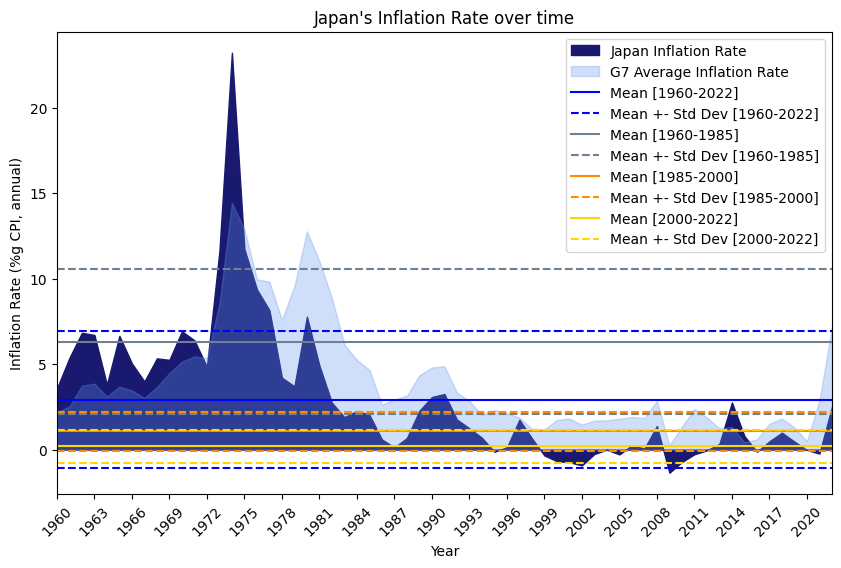

In [43]:
# Stats plotting for Inflation Rate 

# Global dataset 
plt.figure(figsize=(10, 6))
plt.fill_between(DITdf["Year"], DITdf["Inflation Rate"], color="midnightblue", linestyle="-", label="Japan Inflation Rate")

# G7 average inflation trend
plt.fill_between(DITdf["Year"], DITdf["G7 Average Inflation Rate"], color="cornflowerblue", linestyle="-", alpha=0.3, label="G7 Average Inflation Rate")

# Global dataset stats
IR_mean = np.mean(DITdf["Inflation Rate"])
IR_std = np.std(DITdf["Inflation Rate"])
plt.axhline(IR_mean, color="blue", linestyle="-", label="Mean [1960-2022]")
plt.axhline(IR_mean + IR_std, color="blue", linestyle="--", label="Mean +- Std Dev [1960-2022]")
plt.axhline(IR_mean - IR_std, color="blue", linestyle="--")

# Graph settings
plt.style.use("default")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(3)) 
plt.xticks(rotation=45)
plt.title("Japan's Inflation Rate over time")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%g CPI, annual)")
plt.xlim(DITdf["Year"].min(), DITdf["Year"].max())

# Segmented dataset stats
# we segment the global dataset for inflation rate to better highlight the evidence of a change in mean (and std) over time, that cause our data to be globally non-stationary, due to the introduction by the BoJ of new inflation tragets, particularly the 2% target officially set on 2013.
DITdf1 = DITdf.copy() 
DITdf1["Year"] = pd.to_datetime(DITdf1["Year"], format="%Y", errors="coerce")

IR_mean1960to1985 = np.mean(DITdf1.loc[(DITdf1["Year"].dt.year >= 1960) & (DITdf1["Year"].dt.year <= 1985), "Inflation Rate"])
IR_mean1985to2000 = np.mean(DITdf1.loc[(DITdf1["Year"].dt.year >= 1985) & (DITdf1["Year"].dt.year <= 2000), "Inflation Rate"])
IR_mean2000to2022 = np.mean(DITdf1.loc[(DITdf1["Year"].dt.year >= 2000) & (DITdf1["Year"].dt.year <= 2022), "Inflation Rate"])
IR_std1960to1985 = np.std(DITdf1.loc[(DITdf1["Year"].dt.year >= 1960) & (DITdf1["Year"].dt.year <= 1985), "Inflation Rate"])
IR_std1985to2000 = np.std(DITdf1.loc[(DITdf1["Year"].dt.year >= 1985) & (DITdf1["Year"].dt.year <= 2000), "Inflation Rate"])
IR_std2000to2022 = np.std(DITdf1.loc[(DITdf1["Year"].dt.year >= 2000) & (DITdf1["Year"].dt.year <= 2022), "Inflation Rate"])

plt.axhline(IR_mean1960to1985, color="slategrey", linestyle="-", label="Mean [1960-1985]")
plt.axhline(IR_mean1960to1985 + IR_std1960to1985, color="slategrey", linestyle="--", label="Mean +- Std Dev [1960-1985]")
plt.axhline(IR_mean1960to1985 - IR_std1960to1985, color="slategrey", linestyle="--")

plt.axhline(IR_mean1985to2000, color="darkorange", linestyle="-", label="Mean [1985-2000]")
plt.axhline(IR_mean1985to2000 + IR_std1985to2000, color="darkorange", linestyle="--", label="Mean +- Std Dev [1985-2000]")
plt.axhline(IR_mean1985to2000 - IR_std1985to2000, color="darkorange", linestyle="--")

plt.axhline(IR_mean2000to2022, color="gold", linestyle="-", label="Mean [2000-2022]")
plt.axhline(IR_mean2000to2022 + IR_std2000to2022, color="gold", linestyle="--", label="Mean +- Std Dev [2000-2022]")
plt.axhline(IR_mean2000to2022 - IR_std2000to2022, color="gold", linestyle="--")


plt.legend()
plt.show()

# As the graph displays, there is clear evidence of statistically significant changes in mean and std especially between the first cluster (1960-1985) and the two other segments (1985-2000 & 2000-2022). 
# In particular, over the 2013 threshold, there exists a clear reverting tendency of the mean towards values close to the BoJ inflation target (2%). 

In [44]:
# Additional evidence: rerunning ADF & KPSS over the segment 2000-2013
# performing ADF 
ADF_IR_result_2000to2022 = adfuller(DITdf1.loc[(DITdf1["Year"].dt.year >= 2000) & (DITdf1["Year"].dt.year <= 2022), "Inflation Rate"])
ADF_IR_test_statistic_2000to2022 = ADF_IR_result_2000to2022[0]
ADF_IR_p_value_2000to2022 = ADF_IR_result_2000to2022[1] 

print("ADF Test result-Inflation Rate:", ADF_IR_result_2000to2022)
print("ADF Test stastic-Inflation Rate:", ADF_IR_test_statistic_2000to2022)
print("ADF p-value-Inflation Rate:", ADF_IR_p_value_2000to2022)
# not surprisingly, the ADF test statistic for the Inflation Rate is approximately -3.10, with a p-value of 0.027, suggesting strong evidence against the null hypothesis of non-stationarity.

# performing KPSS
KPSS_IR_result_2000to2022 = kpss(DITdf1.loc[(DITdf1["Year"].dt.year >= 2000) & (DITdf1["Year"].dt.year <= 2022), "Inflation Rate"])
KPSS_IR_test_statistic_2000to2022 = KPSS_IR_result_2000to2022[0]
KPSS_IR_p_value_2000to2022 = KPSS_IR_result_2000to2022[1]

print("KPSS Test result-Inflation Rate:", KPSS_IR_result_2000to2022)
print("KPSS Test stastic-Inflation Rate:", KPSS_IR_test_statistic_2000to2022)
print("KPSS p-value-Inflation Rate:", KPSS_IR_p_value_2000to2022)
# the KPSS test statistic is approximately 0.51, with a p-value of 0.039, indicating weak evidence against the null hypothesis of stationarity. 

ADF Test result-Inflation Rate: (-3.098415628336721, 0.026670661478797427, 0, 22, {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}, 40.20783631774414)
ADF Test stastic-Inflation Rate: -3.098415628336721
ADF p-value-Inflation Rate: 0.026670661478797427
KPSS Test result-Inflation Rate: (0.5132514356749432, 0.03868210908221999, 1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test stastic-Inflation Rate: 0.5132514356749432
KPSS p-value-Inflation Rate: 0.03868210908221999


##### 2) Public Debt (%GDP)

In [45]:
# performing ADF on Public Debt data (the null hypothesis assumes that there exists at least one uni-root, which is an highy probable indicator of non-stationarity)
ADF_PD_result = adfuller(DITdf["Public Debt (%GDP)"])
ADF_PD_test_statistic = ADF_PD_result[0]
ADF_PD_p_value = ADF_PD_result[1] 

print("ADF Test result-Public Debt:", ADF_PD_result)
print("ADF Test stastic-Public Debt:", ADF_PD_test_statistic)
print("ADF p-value-Public Debt:", ADF_PD_p_value)
# the ADF test yielded a test statistic of 1.1849 and a p-value of 0.9959. With such a high p-value, we fail to reject the null hypothesis of non-stationarity, indicating that the series likely contains a unit root.

# performing KPSS on Public Debt data (opposite null hypothesis, we assume the data is stationary and follows a deterministic trend)
KPSS_PD_result = kpss(DITdf["Public Debt (%GDP)"])
KPSS_PD_test_statistic = KPSS_PD_result[0]
KPSS_PD_p_value = KPSS_PD_result[1]

print("KPSS Test result-Public Debt:", KPSS_PD_result)
print("KPSS Test stastic-Public Debt:", KPSS_PD_test_statistic)
print("KPSS p-value-Public Debt:", KPSS_PD_p_value)
# the KPSS test returned a test statistic of 1.1054 and a p-value of 0.01. Here, we reject the null hypothesis of stationarity in favor of the alternative, suggesting the presence of a trend.

# As predictable by a widespread historical tendency among advanced economies, this strong tested non-stationarity of our data is to be attributed to the evidence of a positive-sloped trend, non-statistically negligible. 
# The data plotting unequivocally confirmes what tests alredy suggested, pushing for resorting to detrending corrections. It is worth to notice that the causes of what we observe must be saught in macroeconomic policy and financial trends observed in the post-WWII aftermath adn yearly 2000s.

ADF Test result-Public Debt: (1.1848981159999812, 0.995879864498321, 1, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, 316.8708651085588)
ADF Test stastic-Public Debt: 1.1848981159999812
ADF p-value-Public Debt: 0.995879864498321
KPSS Test result-Public Debt: (1.105391651324179, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test stastic-Public Debt: 1.105391651324179
KPSS p-value-Public Debt: 0.01


C:\Users\eland\AppData\Local\Temp\ipykernel_15076\1909309715.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  KPSS_PD_result = kpss(DITdf["Public Debt (%GDP)"])


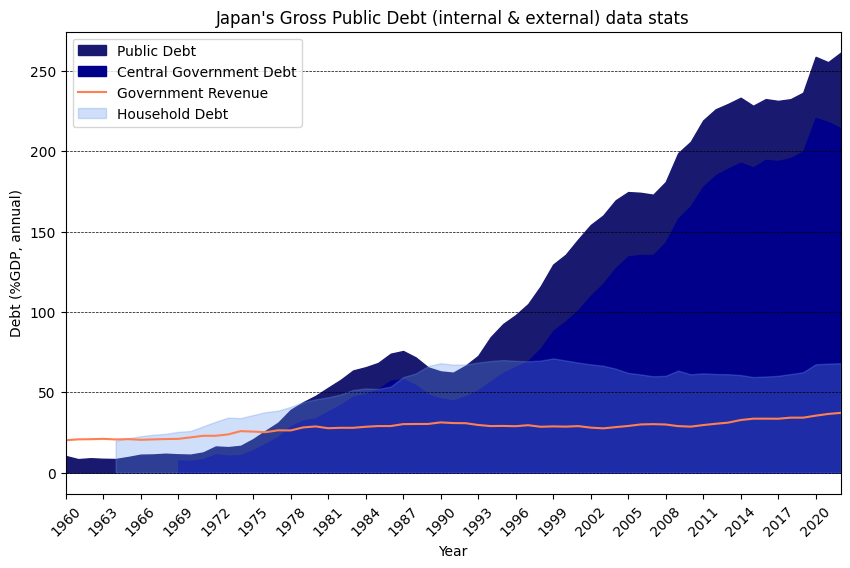

In [46]:
# Stats plotting for Public Debt (%GDP)
plt.figure(figsize=(10, 6))
DITdf["Public Debt (%GDP)"] = pd.to_numeric(DITdf["Public Debt (%GDP)"], errors="coerce")
plt.fill_between(DITdf["Year"], DITdf["Public Debt (%GDP)"], color="midnightblue", linestyle="-", label="Public Debt")

# Additional data
CGDdf["Central Government Debt (%GDP)"] = pd.to_numeric(CGDdf["Central Government Debt (%GDP)"], errors="coerce")
plt.fill_between(CGDdf["Year"], CGDdf["Central Government Debt (%GDP)"], color="darkblue", linestyle="-", label="Central Government Debt")
GRdf["Government Revenue (%GDP)"] = pd.to_numeric(GRdf["Government Revenue (%GDP)"], errors="coerce")
plt.plot(GRdf["Year"], GRdf["Government Revenue (%GDP)"], color="coral", linestyle="-", label="Government Revenue")
HDdf["Household Debt (%GDP)"] = pd.to_numeric(HDdf["Household Debt (%GDP)"], errors="coerce")
plt.fill_between(HDdf["Year"], HDdf["Household Debt (%GDP)"], color="cornflowerblue", linestyle="-", alpha=0.3, label="Household Debt")

# Graph settings
plt.style.use("default")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(3)) 
plt.xticks(rotation=45)
plt.title("Japan's Gross Public Debt (internal & external) data stats")
plt.xlabel("Year")
plt.ylabel("Debt (%GDP, annual)")
plt.grid(axis="y", linestyle="--", linewidth=0.5, color="black")
plt.xlim(DITdf["Year"].min(), DITdf["Year"].max())


plt.legend(loc="upper left")
plt.show()

In [47]:
# Detrending corrections: moving average

# Calculate moving average (with a window size of 5 years)
window_size = 5 
DITdf["Public Debt Moving Average (%GDP)"] = DITdf["Public Debt (%GDP)"].rolling(window=window_size).mean()
DITdf["Detrended Public Debt (%GDP)"] = DITdf["Public Debt (%GDP)"] - DITdf["Public Debt Moving Average (%GDP)"]

print(DataFrame(DITdf["Detrended Public Debt (%GDP)"]))

    Detrended Public Debt (%GDP)
0                            NaN
1                            NaN
2                            NaN
3                            NaN
4                      -0.485298
..                           ...
58                      0.844918
59                      4.260487
60                     20.453696
61                     12.546234
62                     12.447126

[63 rows x 1 columns]


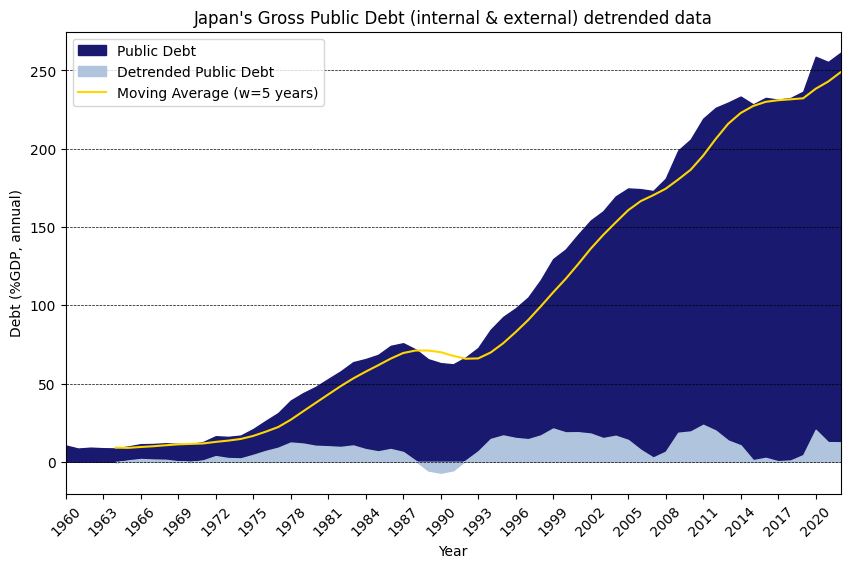

In [94]:
# Detrended data plotting
plt.figure(figsize=(10, 6))
DITdf["Public Debt (%GDP)"] = pd.to_numeric(DITdf["Public Debt (%GDP)"], errors="coerce")
plt.fill_between(DITdf["Year"], DITdf["Public Debt (%GDP)"], color="midnightblue", linestyle="-", label="Public Debt")

DITdf["Detrended Public Debt (%GDP)"] = pd.to_numeric(DITdf["Detrended Public Debt (%GDP)"], errors="coerce")
plt.fill_between(DITdf["Year"], DITdf["Detrended Public Debt (%GDP)"], color="lightsteelblue", linestyle="-", label="Detrended Public Debt")
DITdf["Public Debt Moving Average (%GDP)"] = pd.to_numeric(DITdf["Public Debt Moving Average (%GDP)"], errors="coerce")
plt.plot(DITdf["Year"], DITdf["Public Debt Moving Average (%GDP)"], color="gold", linestyle="-", label="Moving Average (w=5 years)")

# Graph settings
plt.style.use("default")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(3)) 
plt.xticks(rotation=45)
plt.title("Japan's Gross Public Debt (internal & external) detrended data")
plt.xlabel("Year")
plt.ylabel("Debt (%GDP, annual)")
plt.grid(axis="y", linestyle="--", linewidth=0.5, color="black")
plt.xlim(DITdf["Year"].min(), DITdf["Year"].max())


plt.legend(loc="upper left")
plt.show()

In [49]:
# Additional evidence: rerunning ADF & KPSS on detrended data
# remove NaNs within the dataframe 
PDD_data = DITdf["Detrended Public Debt (%GDP)"]
PDD_clean = PDD_data.dropna()

# performing ADF 
ADF_PDD_result = adfuller(PDD_clean)
ADF_PDD_test_statistic = ADF_PDD_result[0]
ADF_PDD_p_value = ADF_PDD_result[1] 

print("ADF Test result-Detrended Public Debt:", ADF_PDD_result)
print("ADF Test stastic-Detrended Public Debt:", ADF_PDD_test_statistic)
print("ADF p-value-Detrended Public Debt:", ADF_PDD_p_value)
# as expected, with a test statistic of -3.2479, we reject the null hypothesis of non-stationarity at the 5% significance level (p-value = 0.0173), indicating evidence of stationarity in the detrended public debt data.

# performing KPSS
KPSS_PDD_result = kpss(PDD_clean)
KPSS_PDD_test_statistic = KPSS_PDD_result[0]
KPSS_PDD_p_value = KPSS_PDD_result[1]

print("KPSS Test result-Detrended Public Debt:", KPSS_PDD_result)
print("KPSS Test stastic-Detrended Public Debt:", KPSS_PDD_test_statistic)
print("KPSS p-value-Detrended Public Debt:", KPSS_PDD_p_value)
#  equally, with a test statistic of 0.4228 and a p-value of 0.0673, we fail to reject the null hypothesis of stationarity at the 5% significance level, leading to confirm that there is weak evidence against the null hypothesis of stationarity in the detrended data. 

ADF Test result-Detrended Public Debt: (-3.2479155049534905, 0.0173733588542922, 2, 56, {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}, 273.79351279687467)
ADF Test stastic-Detrended Public Debt: -3.2479155049534905
ADF p-value-Detrended Public Debt: 0.0173733588542922
KPSS Test result-Detrended Public Debt: (0.4227872901514822, 0.06733306458987837, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test stastic-Detrended Public Debt: 0.4227872901514822
KPSS p-value-Detrended Public Debt: 0.06733306458987837


### **Data plotting**

In [50]:
import pandas as pd
from pandas import DataFrame 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

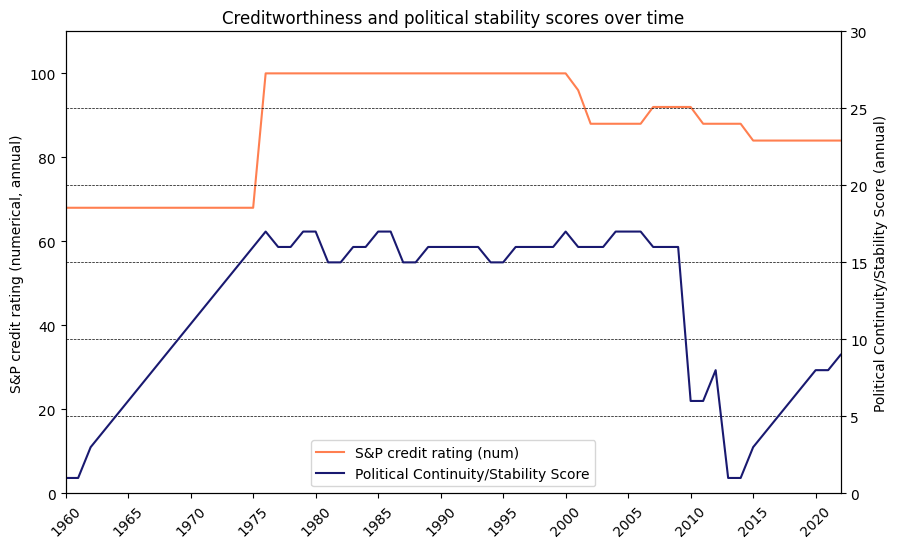

In [51]:
# Creditworthiness and political stability score data plotting
fig, ax1 = plt.subplots(figsize=(10, 6))
DITdf["Numerical Index"] = pd.to_numeric(DITdf["Numerical Index"], errors="coerce")
ax1.plot(DITdf["Year"], DITdf["Numerical Index"], color="coral", linestyle="-", label="S&P credit rating (num)")

ax2 = ax1.twinx()
DITdf["Political Continuity/Stability Score"] = pd.to_numeric(DITdf["Political Continuity/Stability Score"], errors="coerce")
ax2.plot(DITdf["Year"], DITdf["Political Continuity/Stability Score"], color="midnightblue", linestyle="-", label="Political Continuity/Stability Score")

# Graph settings
plt.style.use("default")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5)) 
ax1.tick_params(axis="x", rotation=45)
plt.title("Creditworthiness and political stability scores over time")
plt.xlabel("Year")
ax1.set_ylabel("S&P credit rating (numerical, annual)")
ax2.set_ylabel("Political Continuity/Stability Score (annual)")
ax1.set_ylim(0, 110) 
ax2.set_ylim(0, 30) 
plt.grid(axis="y", linestyle="--", linewidth=0.5, color="black")
plt.xlim(DITdf["Year"].min(), DITdf["Year"].max())

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower center")
plt.show()

### **Model Specification**

In [52]:
import pandas as pd
from pandas import DataFrame 
import numpy as np
import statsmodels.api as sm

In [53]:
# dataframe overview
print(DataFrame(DITdf))

    Year S&P credit rating  Numerical Index  Inflation Rate  \
0   1960               BBB               68        3.574512   
1   1961               BBB               68        5.368462   
2   1962               BBB               68        6.835440   
3   1963               BBB               68        6.706906   
4   1964               BBB               68        3.800389   
..   ...               ...              ...             ...   
58  2018                A+               84        0.989095   
59  2019                A+               84        0.468776   
60  2020                A+               84       -0.024996   
61  2021                A+               84       -0.233353   
62  2022                A+               84        2.497703   

    G7 Average Inflation Rate  JPN-G7 Inflation Gap  \
0                    2.203067              1.371445   
1                    2.521468              2.846994   
2                    3.736855              3.098586   
3                    3.

##### 1) Model specification 1: Global Model

In [54]:
# Regression model specification 1: Global Model 

# define our dependent variable (Y)
Y1 = DITdf["Numerical Index"]

# introduce the explanatory variables in the model (Xn) 
X1 = DITdf[["Inflation Rate", "JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X1 = sm.add_constant(X1)

# run and fit the model
model1 = sm.OLS(Y1, X1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     54.99
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.08e-21
Time:                        19:41:27   Log-Likelihood:                -188.96
No. Observations:                  63   AIC:                             391.9
Df Residuals:                      56   BIC:                             406.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

##### 2) Model specification 2: Detrended Global Model

In [55]:
# Regression model specification 2: Detrended Global Model  
# additionaly, the second variant of the model includes detrended and stationarity-cleaned data for Public Debt (%GDP) substituting the previous raw ones, presenting evidence of a trend tendency.  

# data manipulation
DITdf2 = DITdf.copy()
DITdf2 = DITdf2.dropna()
DITdf2 = DITdf2.reset_index(drop=True)

# define our dependent variable (Y)
Y2 = DITdf2["Numerical Index"]

# introduce the explanatory variables, including the cleaned ones, in the model (Xn)
X2 = DITdf2[["Inflation Rate", "JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Detrended Public Debt (%GDP)"]]
X2 = sm.add_constant(X2)

# run and fit the model
model2 = sm.OLS(Y2, X2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     43.14
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.72e-18
Time:                        19:41:27   Log-Likelihood:                -177.98
No. Observations:                  59   AIC:                             370.0
Df Residuals:                      52   BIC:                             384.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

##### 3) Model specification 3: Inflation-Austerity Model

In [78]:
# Regression model specification 3: Inflation-Austerity Model
# we now replace our raw and non-stationary data on Inflation Rate with the cleaned ones from the time segment 2000-2022, conveying mean-reverted and constant std patterns. 
# it is worth to notice that with this dataframe structure, we need to remove data from "Years of Default/Restructuring" as during the 2000-2022 time span, we do not observe any variation, reducing in this way the global efficiency of our model (no bias). 

# data manipulation
DITdf3 = DITdf.copy()
DITdf3 = DITdf3.drop(index=range(0, 40))
DITdf3 = DITdf3.reset_index(drop=True)

# define our dependent variable (Y)
Y3 = DITdf3["Numerical Index"]

# introduce the explanatory variables, including the cleaned ones, in the model (Xn)
X3 = DITdf3[["Inflation Rate", "JPN-G7 Inflation Gap", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X3 = sm.add_constant(X3)

# run and fit the model
model3 = sm.OLS(Y3, X3)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5.589
Date:                Wed, 01 May 2024   Prob (F-statistic):            0.00317
Time:                        20:01:31   Log-Likelihood:                -54.278
No. Observations:                  23   AIC:                             120.6
Df Residuals:                      17   BIC:                             127.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

##### 4) Model specification 4: Restricted Inflation-Austerity Model

In [74]:
# Regression model specification 4: Restricted Inflation-Austerity Model
# unlike model specification 3, here we additionaly exclude proxy variables characterized by low-variance, i.e., "Years of Default/Restructuring" & "Years since last Default/Restructuring" (keeping the time segment (2000-2022) unchanged).
# given the restricted nature of the model and aiming to avoid multicollinearity issues, we keep only one of the two indicators tracking the underlying inflation dynamics. 

# data manipulation
DITdf4 = DITdf.copy()
DITdf4 = DITdf4.drop(index=range(0, 40))
DITdf4 = DITdf4.reset_index(drop=True)

# define our dependent variable (Y)
Y4 = DITdf4["Numerical Index"]

# introduce the explanatory variables, including the cleaned ones, in the model (Xn)
X4 = DITdf4[["Inflation Rate", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X4 = sm.add_constant(X4)

# run and fit the model
model4 = sm.OLS(Y4, X4)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     9.393
Date:                Wed, 01 May 2024   Prob (F-statistic):           0.000509
Time:                        19:54:40   Log-Likelihood:                -55.000
No. Observations:                  23   AIC:                             118.0
Df Residuals:                      19   BIC:                             122.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### **Robustness checks**

In [58]:
import pandas as pd
from pandas import DataFrame 
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools import add_constant
from scipy.stats import shapiro
from scipy.stats import chi2
from linearmodels.iv import IV2SLS

##### 1) First-order autocorrelation check

In [79]:
# First-order autocorrelation check
# lag=1
autocorrelation = DITdf["Numerical Index"].autocorr()
print("First-order autocorrelation:", autocorrelation)

# In the case of credit rating dynamics, including autocorrelation in the model may lack conceptual relevance and not provide further relevant insights, despite its statistically significant high value (0.943), which is not surprising given the low-variance feature of the phenomena. 
# Moreover, its inclusion could introduce multicollinearity issues without enhancing the interpretability of the model. 

First-order autocorrelation: 0.9430162882552434


##### 2) Non-normality of error terms tests

In [60]:
# Jarque-Bera Test
# Running regressions on Python provides you already with Jarque-Bera's test statistics, assessing if the error terms follow a distribution close to the normal, according to their skewness and kurtosis statistics.
# In our case, in model specification 1 and 2, the high Jarque-Bera test statistics (140.103 and 89.793, respectively) coupled with very low p-values (Prob(JB) < 0.05) strongly suggest significant deviations from normality in residuals, probably mainly due to similar non-mean reverted dynamics to the ones that we have observed for Public Debt data. 
# Conversely as predictable, model specification 3 and 4 exhibit markedly lower Jarque-Bera statistics (0.324 and 0.763, respectively) with correspondingly higher p-values (Prob(JB) > 0.05), indicating a lack of evidence to reject the null hypothesis of normality in residuals for these models. 

In [81]:
# Shapiro-Wilk test 
shapiro_statistic1, shapiro_p_value1 = shapiro(results1.resid)
shapiro_statistic2, shapiro_p_value2 = shapiro(results2.resid)
shapiro_statistic3, shapiro_p_value3 = shapiro(results3.resid)
shapiro_statistic4, shapiro_p_value4 = shapiro(results4.resid)

print("Shapiro-Wilk test statistics:", shapiro_statistic1, shapiro_statistic2, shapiro_statistic3, shapiro_statistic4)
print("Shapiro-Wilk p-values:", shapiro_p_value1, shapiro_p_value2, shapiro_p_value3, shapiro_p_value4)

# As proof of what previously assessed, Shapiro-Wilk tests were run on all four regression models. In line with JB's findings, for model 1 and model 2, the results revealed notably low Shapiro-Wilk statistics (0.8765 and 0.9055, respectively) coupled with exceedingly small p-values (p < 0.05), indicating possible deviations from normality in residuals. 
# Mirroring JB, the third model displayed a Shapiro-Wilk statistic of 0.9886, accompanied by a notably high p-value (0.9929), signifying no compelling evidence to refuse the assumption of normality in residuals. 
# Similarly, in model 4, the Shapiro-Wilk statistic was 0.9577, with a moderate p-value (0.4181), further supporting the notion of residuals conforming to a normal distribution. 

Shapiro-Wilk test statistics: 0.8765243887901306 0.9055104851722717 0.9885508418083191 0.9576776623725891
Shapiro-Wilk p-values: 1.3348992979445029e-05 0.00023736785806249827 0.9928932785987854 0.418115496635437


##### 3) Functional form tests

In [82]:
# Ramsey reset test
# power=2 indicates that the test will include additional terms that are the square of the fitted values.
reset_test1 = linear_reset(results1, power=2)
reset_test2 = linear_reset(results2, power=2)
reset_test3 = linear_reset(results3, power=2)
reset_test4 = linear_reset(results4, power=2)

print("Ramsey RESET test stats for mod1:", reset_test1)
print("Ramsey RESET test stats for mod2:", reset_test2)
print("Ramsey RESET test stats for mod3:", reset_test3)
print("Ramsey RESET test stats for mod4:", reset_test4)

# Across all models, the p-values exceed the conventional significance threshold of 0.05, indicating no strong evidence to reject the null hypothesis of correct functional form specification. 
# Thus, there is no indication of significant misspecification in the functional forms of the regression models based on the Ramsey RESET test results. 
# It is also worth to notice that among all specifications, we do not dected potential issue of harmful levels of data-noise-capturing, according to adjusted R-squared statistics.

Ramsey RESET test stats for mod1: <Wald test (chi2): statistic=2.7590606984559574, p-value=0.09670500132923136, df_denom=1>
Ramsey RESET test stats for mod2: <Wald test (chi2): statistic=2.209015774499965, p-value=0.13720618319324204, df_denom=1>
Ramsey RESET test stats for mod3: <Wald test (chi2): statistic=0.5752895358123786, p-value=0.44816461839942334, df_denom=1>
Ramsey RESET test stats for mod4: <Wald test (chi2): statistic=1.2237797696396067, p-value=0.26862014420121305, df_denom=1>


##### 4) Heteroscedasticity robustness test

In [83]:
# Breusch-Pagan test
# set the test requirements
exog_with_constant1 = results1.model.exog
exog_with_constant2 = results2.model.exog
exog_with_constant3 = results3.model.exog
exog_with_constant4 = results4.model.exog

# run the test with the constant term
bp_test1 = het_breuschpagan(results1.resid, exog_with_constant1)
bp_test2 = het_breuschpagan(results2.resid, exog_with_constant2)
bp_test3 = het_breuschpagan(results3.resid, exog_with_constant3)
bp_test4 = het_breuschpagan(results4.resid, exog_with_constant4)

# extract test statistics and p-values for each model specification
bp_statistic1 = bp_test1[0]
bp_p_value1 = bp_test1[1]
bp_statistic2 = bp_test2[0]
bp_p_value2 = bp_test2[1]
bp_statistic3 = bp_test3[0]
bp_p_value3 = bp_test3[1]
bp_statistic4 = bp_test4[0]
bp_p_value4 = bp_test4[1]

print("Breusch-Pagan test statistic:", bp_statistic1, bp_statistic2, bp_statistic3, bp_statistic4)
print("Breusch-Pagan test p-value:", bp_p_value1, bp_p_value2, bp_p_value3, bp_p_value4)

# The obtained p-values suggest that there is evidence of heteroscedasticity in the error terms for model 1 (0.00455), model 3 (0.03388) and model 4 (0.01139), while specification 2 does not exhibit significant evidence of heteroscedasticity (0.10313). 
# This implies that the assumption of homoscedasticity may not hold for three first mentioned models, potentially affecting the reliability of their parameter estimates and inferential conclusions.

Breusch-Pagan test statistic: 18.78026467240525 10.555406154433955 12.06691553711241 11.063456829321334
Breusch-Pagan test p-value: 0.004551283759534665 0.10312803876338704 0.033882298427713446 0.011387642879450259


In [84]:
# White test
# even for White test, we need to rely on the constant term we manually add for BP test
white_test1 = het_white(results1.resid, exog_with_constant1)
white_test2 = het_white(results2.resid, exog_with_constant2)
white_test3 = het_white(results3.resid, exog_with_constant3)
white_test4 = het_white(results4.resid, exog_with_constant4)

# extract test statistics and p-values for each model specification
white_statistic1 = white_test1[0]
white_pvalue1 = white_test1[1]
white_statistic2 = white_test2[0]
white_pvalue2 = white_test2[1]
white_statistic3 = white_test3[0]
white_pvalue3 = white_test3[1]
white_statistic4 = white_test4[0]
white_pvalue4 = white_test4[1]

print("White test statistic:", white_statistic1, white_statistic2, white_statistic3, white_statistic4)
print("White test p-value:", white_pvalue1, white_pvalue2, white_pvalue3, white_pvalue4)

# The White test identified significant heteroscedasticity in the error terms of model specification 1 (0.00681) and 2 (0.00140), implying varying variance across independent variable levels. 
# However, model 3 (0.38981) and model 4 (0.08497) exhibited no significant evidence of heteroscedasticity, suggesting stable variance in their error terms. 
# Eventually, the White test results were not globally alligned with our previous findings from BP, instead they appear slightly controversial in the interpretation of heteroscedasticity evidence, calling for specifications-spread heteroscedasticity corrections. 

White test statistic: 48.459489115198 54.289098922162175 21.124952913578433 15.223442288413443
White test p-value: 0.00681933069647358 0.0014022516451338495 0.3898110093746949 0.08497842829485962


In [86]:
# Heteroscedasticity corrections
# extracting the regression results using HC3 estimator for robust standard errors 
results1_robust = model1.fit(cov_type="HC3")  
results2_robust = model2.fit(cov_type="HC3") 
results3_robust = model3.fit(cov_type="HC3") 
results4_robust = model4.fit(cov_type="HC3") 

print(results1_robust.summary())
print(results2_robust.summary())
print(results3_robust.summary())
print(results4_robust.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     209.7
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.68e-36
Time:                        20:39:11   Log-Likelihood:                -188.96
No. Observations:                  63   AIC:                             391.9
Df Residuals:                      56   BIC:                             406.9
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

##### 5) Endogeneity robustness test

In [87]:
# Two-stage IV regression
# we suspect a potential correlation between the error term (omitted variables bundle) and the Inflation Rate over time and two adress that we deploy a two stage intrumental variables regression.
# instrumental variable: Yen to U.S. Dollar Spot Exchange Rate

# data merging
DITdf5 = DITdf.copy()
DITdf5 = pd.merge(DITdf5, YENdf, on="Year", how="outer")
DITdf5 = DITdf5.dropna().reset_index(drop=True)

# 1st stage  
# stage settings, we manually add the constant term to the exog component 
instrument = DITdf5["Yen-USD Spot Exchange"]
instrument_with_constant = sm.add_constant(instrument)

# we regress our variable at endogeneity risk on the instrument (Yen to U.S. Dollar Spot Exchange Rate)
first_stage_model = sm.OLS(endog=DITdf5["Inflation Rate"], exog=instrument_with_constant).fit()
predicted_endogenous = first_stage_model.predict(instrument_with_constant)
DITdf5["Predicted endogenous variable (IR)"] = predicted_endogenous
print(first_stage_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Inflation Rate   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     67.61
Date:                Wed, 01 May 2024   Prob (F-statistic):           7.55e-11
Time:                        20:39:16   Log-Likelihood:                -126.35
No. Observations:                  52   AIC:                             256.7
Df Residuals:                      50   BIC:                             260.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.66

In [89]:
# 2nd stage
# data manipulation 
DITdf6 = DITdf5.copy()
DITdf6 = DITdf6.dropna()
DITdf6 = DITdf6.reset_index(drop=True)

DITdf7 = DITdf5.copy()
DITdf7 = DITdf7.drop(index=range(0, 40))
DITdf7 = DITdf7.reset_index(drop=True)

# we now employ the predicted values from the 1st stage as regressors in the second-stage regression for each model specification
Y21 = DITdf5["Numerical Index"]
X21 = DITdf5[["Predicted endogenous variable (IR)", "JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X21 = sm.add_constant(X21)
Y22 = DITdf6["Numerical Index"]
X22 = DITdf6[["Predicted endogenous variable (IR)", "JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Detrended Public Debt (%GDP)"]]
X22 = sm.add_constant(X22)
Y23 = DITdf7["Numerical Index"]
X23 = DITdf7[["Predicted endogenous variable (IR)", "JPN-G7 Inflation Gap", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X23 = sm.add_constant(X23)
Y24 = DITdf7["Numerical Index"]
X24 = DITdf7[["Predicted endogenous variable (IR)", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
X24 = sm.add_constant(X24)

second_stage_model1 = sm.OLS(Y21, X21).fit()
second_stage_model2 = sm.OLS(Y22, X22).fit()
second_stage_model3 = sm.OLS(Y23, X23).fit()
second_stage_model4 = sm.OLS(Y24, X24).fit()

print(second_stage_model1.summary())
print(second_stage_model2.summary())
print(second_stage_model3.summary())
print(second_stage_model4.summary())

                            OLS Regression Results                            
Dep. Variable:        Numerical Index   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     26.69
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.70e-13
Time:                        20:40:17   Log-Likelihood:                -153.81
No. Observations:                  52   AIC:                             321.6
Df Residuals:                      45   BIC:                             335.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

c:\Users\eland\miniconda3\envs\X\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\eland\miniconda3\envs\X\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [93]:
# Testing the validity of the instrument
 
# First-Stage F-Statistic
# The First stage F-statistic of 67.61 with a p-value of 7.55e-11 indicates that our instrumental variable, Yen U.S. Dollar Spot Exchange Rate, is jointly significant in explaining the endogenous variable. 
# This suggests that the instrumental variable is likely valid and relevant for addressing endogeneity in our regression model, regardless its specification. 

# Wu-Hausman test
# we manually reset the 2SLS IV regression according to the package scheme 
exogenousIV1 = DITdf5[["JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
exogenousIV1 = sm.add_constant(exogenousIV1)
exogenousIV2 = DITdf6[["JPN-G7 Inflation Gap", "Years of Default/Restructuring", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Detrended Public Debt (%GDP)"]]
exogenousIV2 = sm.add_constant(exogenousIV2)
exogenousIV3 = DITdf7[["JPN-G7 Inflation Gap", "Years since last Default/Restructuring", "Political Continuity/Stability Score", "Public Debt (%GDP)"]]
exogenousIV3 = sm.add_constant(exogenousIV3)
exogenousIV4 = DITdf7[["Political Continuity/Stability Score", "Public Debt (%GDP)"]]
exogenousIV4 = sm.add_constant(exogenousIV4)

# Fit the IV2SLS model
iv_model1 = IV2SLS(dependent=DITdf5["Numerical Index"], exog=exogenousIV1, endog=DITdf5["Inflation Rate"], instruments=DITdf5["Yen-USD Spot Exchange"])
iv_results1 = iv_model1.fit()
iv_model2 = IV2SLS(dependent=DITdf6["Numerical Index"], exog=exogenousIV2, endog=DITdf6["Inflation Rate"], instruments=DITdf6["Yen-USD Spot Exchange"])
iv_results2 = iv_model2.fit()
iv_model3 = IV2SLS(dependent=DITdf7["Numerical Index"], exog=exogenousIV3, endog=DITdf7["Inflation Rate"], instruments=DITdf7["Yen-USD Spot Exchange"])
iv_results3 = iv_model3.fit()
iv_model4 = IV2SLS(dependent=DITdf7["Numerical Index"], exog=exogenousIV4, endog=DITdf7["Inflation Rate"], instruments=DITdf7["Yen-USD Spot Exchange"])
iv_results4 = iv_model4.fit()

# Calculate the Wu-Hausman statistic and its p-value manually
wu_hausman_test1 = iv_results1.wu_hausman()
wu_hausman_test2 = iv_results2.wu_hausman()
wu_hausman_test3 = iv_results3.wu_hausman()
wu_hausman_test4 = iv_results4.wu_hausman()

print(wu_hausman_test1, wu_hausman_test2, wu_hausman_test3, wu_hausman_test4)

# As predictable, for the first two models, the test statistics are 1.0061 and 0.9934, with corresponding p-values of 0.3213 and 0.3244, respectively. These p-values are greater than the conventional significance level of 0.05, suggesting no significant evidence to reject the null hypothesis that all endogenous variables are exogenous for these models. 
# However, for the third and fourth models, the test statistics are substantially larger (35.2713 and 58.2808, respectively), with much smaller p-values of 0.0019 and 0.0001. These results indicate significant evidence to reject the null hypothesis, implying that all endogenous variables may not be exogenous in these models.  
# Causes of this assumption breach will be broadly deepen in the paper. 

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1.0061
P-value: 0.3213
Distributed: F(1,44) Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.9934
P-value: 0.3244
Distributed: F(1,44) Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 35.2713
P-value: 0.0019
Distributed: F(1,5) Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 58.2808
P-value: 0.0001
Distributed: F(1,7)
